## Getting data

In [1]:
from __future__ import division, print_function, absolute_import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from datatools.preprocessing import identify_missing_values, preprocess_duplicates
from datatools.music import number_tracks, genre_weekday

RANDOM_STATE = 12345

After importing necessary libraries, we can download the data and look at it.

In [2]:
music_data = pd.read_csv("yandex_music_project.csv")
music_data.sample(10, random_state=RANDOM_STATE)

,userID,Track,artist,genre,City,time,Day
33917,A37C9C06,Little Death,I M U R,electronic,Moscow,13:46:11,Monday
32592,1DF57B3A,Studio n. 4,Eolo Taffi,classical,Moscow,13:51:33,Friday
27919,FAF416,Inondés de non-dits,NaN,pop,Saint-Petersburg,13:44:50,Friday
35525,4A7CC362,Golden Days,Kem,urban,Saint-Petersburg,14:03:55,Wednesday
6524,3360D38B,NaN,NaN,NaN,Saint-Petersburg,21:22:44,Monday
24999,C44C3EF9,Already Gone,Glitterbitch,pop,Saint-Petersburg,21:40:08,Monday
29516,37B4795F,Healing Sound of Nature,Henry Floyd,ambient,Saint-Petersburg,08:04:56,Monday
16037,1E337310,Empty Room,Celesty,rock,Saint-Petersburg,14:30:11,Monday
45763,BECFFF40,Su Preferido,J Angel,latin,Saint-Petersburg,08:11:27,Monday
17820,FD83C35E,Трава у дома - Live,Сергей Васильев,world,Moscow,09:30:53,Monday


The data has been uploaded successfully and we can see from 10 randomly selected rows that we have information on plays of different musical tracks which are also characterized by artist, genre as well as some other user data. Now, we can consider the data in a bit more detail.

In [3]:
music_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65079 entries, 0 to 65078
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0     userID  65079 non-null  object
 1   Track     63848 non-null  object
 2   artist    57876 non-null  object
 3   genre     63881 non-null  object
 4     City    65079 non-null  object
 5   time      65079 non-null  object
 6   Day       65079 non-null  object
dtypes: object(7)
memory usage: 3.5+ MB


It can be seen that the data contains 7 columns of `object` data type which contain the following information:

<table>
<thead>
<tr><th>Columns</th><th>Description</th></tr>
</thead>
<tbody>
<tr><td><code>userID</code></td><td style="text-align: center"><i>User identification number</i></td></tr>
<tr><td><code>Track</code></td><td style="text-align: center"><i>Name of a music track</i></td></tr>
<tr><td><code>artist</code></td><td style="text-align: center"><i>Name of an artist</i></td></tr>
<tr><td><code>genre</code></td><td style="text-align: center"><i>Name of a music genre</i></td></tr>
<tr><td><code>City</code></td><td style="text-align: center"><i>City where a song was played</i></td></tr>
<tr><td><code>time</code></td><td style="text-align: center"><i>Time at which a user started listening to a song</i></td></tr>
<tr><td><code>Day</code></td><td style="text-align: center"><i>Day of the week</i></td></tr>
</tbody>
</table>

**Conclusion**

Each row of the DataFrame contains information about different songs of a particular genre and of a particular artist, which users were listening to at a particular time and on a particular day of the week. In addition, we see that users are from different cities.

There are three problems that are to be solved: inadequate column names, missing values and a potential presence of duplicates in data. In order to test working hypotheses, information contained in columns `time`, `Day` and `City` will be especially useful. Furthermore, the data from `genre` column will allow determining the most popular genres. Now, we can get to preprocessing our data.

## Data preprocessing

### Headers style

In [4]:
print(f"Old column names: {music_data.columns.to_list()}")

music_data.columns = music_data.columns.str.lower().str.replace(" ", "")
music_data = music_data.rename(columns={"userid": "user_id"})

print(f"New column names: {music_data.columns.to_list()}")

Old column names: ['  userID', 'Track', 'artist', 'genre', '  City  ', 'time', 'Day']
New column names: ['user_id', 'track', 'artist', 'genre', 'city', 'time', 'day']


### Missing values

In order to check the data for missing values, let's use `identify_missing_values()` function which we defined in a `toolkit` module we created.

In [5]:
# Computing the number and percentage of missing values in the DataFrame
miss_vals_df = identify_missing_values(data=music_data)
display(miss_vals_df)

,dtype,missing_count,missing_fraction
artist,object,7203,0.1107
track,object,1231,0.0189
genre,object,1198,0.0184


Missing values refer to the fact that we do not have all available information for some tracks. There can be a lot of different reasons for this: on the one hand, the artist of some song might not have been specified or, on the other hand, in a worse case scenario, there can be problems with data recording itself.

Missing values in `track` and `artist` are not so important for the subsequent data analysis so we can just replace these values with some explicit notation. The information contained in `genre` column, however, is crucial and can complicate the comparison of musical tastes in Moscow and Saint-Petersburg. Thus, in this case we will have to also replace such values with some explicit notation and afterwards evaluate how much they will affect the analysis results.

To deal with such a problem, we can replace the missing values in columns `track`, `artist` and `genre` with some string placeholder value - `unknown`, for instance.

In [6]:
columns_to_replace = miss_vals_df.index
for column in columns_to_replace:
    music_data[column] = music_data[column].fillna("unknown")

identify_missing_values(data=music_data)

Missing values are not found.


### Duplicates

Compute the number of explicit duplicates (in other words, fully identical DataFrame rows).

In [7]:
preprocess_duplicates(data=music_data)

3,826 duplicates found and deleted.


Now, we need to get rid of implicit duplicates. This can be the case, for instance, when the name of the same genre could have been written down in different ways. As a result, such mistakes can have an adverse impact upon results of the analysis.

Let's start by displaying the unique genre names in the alphabetical order.

In [8]:
print(music_data["genre"].sort_values().unique())

['acid' 'acoustic' 'action' 'adult' 'africa' 'afrikaans' 'alternative'
 'alternativepunk' 'ambient' 'americana' 'animated' 'anime' 'arabesk'
 'arabic' 'arena' 'argentinetango' 'art' 'audiobook' 'author' 'avantgarde'
 'axé' 'baile' 'balkan' 'beats' 'bigroom' 'black' 'bluegrass' 'blues'
 'bollywood' 'bossa' 'brazilian' 'breakbeat' 'breaks' 'broadway'
 'cantautori' 'cantopop' 'canzone' 'caribbean' 'caucasian' 'celtic'
 'chamber' 'chanson' 'children' 'chill' 'chinese' 'choral' 'christian'
 'christmas' 'classical' 'classicmetal' 'club' 'colombian' 'comedy'
 'conjazz' 'contemporary' 'country' 'cuban' 'dance' 'dancehall' 'dancepop'
 'dark' 'death' 'deep' 'deutschrock' 'deutschspr' 'dirty' 'disco' 'dnb'
 'documentary' 'downbeat' 'downtempo' 'drum' 'dub' 'dubstep' 'eastern'
 'easy' 'electronic' 'electropop' 'emo' 'entehno' 'epicmetal' 'estrada'
 'ethnic' 'eurofolk' 'european' 'experimental' 'extrememetal' 'fado'
 'fairytail' 'film' 'fitness' 'flamenco' 'folk' 'folklore' 'folkmetal'
 'folkrock' 

By skimming through the names of genres, it can be seen that we have the following implicit duplicates:

* `hip`
* `hop`
* `hip-hop`

We need to get rid of such duplicates by replacing the duplicated names with one common name `hiphop`:

In [9]:
music_data["genre"] = music_data["genre"].replace(["hip", "hop", "hip-hop"], "hiphop")

Verify whether we correctly got rid of duplicates.

In [10]:
print(music_data["genre"].sort_values().unique())

['acid' 'acoustic' 'action' 'adult' 'africa' 'afrikaans' 'alternative'
 'alternativepunk' 'ambient' 'americana' 'animated' 'anime' 'arabesk'
 'arabic' 'arena' 'argentinetango' 'art' 'audiobook' 'author' 'avantgarde'
 'axé' 'baile' 'balkan' 'beats' 'bigroom' 'black' 'bluegrass' 'blues'
 'bollywood' 'bossa' 'brazilian' 'breakbeat' 'breaks' 'broadway'
 'cantautori' 'cantopop' 'canzone' 'caribbean' 'caucasian' 'celtic'
 'chamber' 'chanson' 'children' 'chill' 'chinese' 'choral' 'christian'
 'christmas' 'classical' 'classicmetal' 'club' 'colombian' 'comedy'
 'conjazz' 'contemporary' 'country' 'cuban' 'dance' 'dancehall' 'dancepop'
 'dark' 'death' 'deep' 'deutschrock' 'deutschspr' 'dirty' 'disco' 'dnb'
 'documentary' 'downbeat' 'downtempo' 'drum' 'dub' 'dubstep' 'eastern'
 'easy' 'electronic' 'electropop' 'emo' 'entehno' 'epicmetal' 'estrada'
 'ethnic' 'eurofolk' 'european' 'experimental' 'extrememetal' 'fado'
 'fairytail' 'film' 'fitness' 'flamenco' 'folk' 'folklore' 'folkmetal'
 'folkrock' 

### Data cleaning results

Lastly, let's print a concise summary of the DataFrame again to make sure that we have correctly conducted data cleaning.

In [11]:
music_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61253 entries, 0 to 65078
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  61253 non-null  object
 1   track    61253 non-null  object
 2   artist   61253 non-null  object
 3   genre    61253 non-null  object
 4   city     61253 non-null  object
 5   time     61253 non-null  object
 6   day      61253 non-null  object
dtypes: object(7)
memory usage: 3.7+ MB


**Conclusion**

Data preprocessing has identified 3 problems in data:

* Inadequate headers style;
* Missing values;
* Duplicates - explicit and implicit.

We have managed to simplify working with the DataFrame, thanks to which the results of the data analysis will be more accurate. The missing values in `genre`, `artist` and `track` columns have been replaced with `unknown` but there is still work to do to understand whether this will affect the results. 

Now, we can get to testing the main hypotheses.

## Hypotheses testing

### H1: Do people really listen to music differently in different cities?

The first hypothesis states that users listen to music differently in Moscow and Saint-Petersburg. We can test this hypothesis by making use of data on three weekdays: Monday, Wednesday and Friday. In order to accomplish that, we need to:

* Divide users into two groups: Moscow users and Saint-Peterburg users;
* Compare the number of tracks listened to by each user group on each available weekday: Monday, Wednesday and Friday.

To better understand the behavior of each user group, let's first estimate the activity of users in each city.

In [12]:
music_data.groupby("city")["user_id"].count()

city
Moscow              42741
Saint-Petersburg    18512
Name: user_id, dtype: int64

There are more track plays in Moscow than in Saint-Petersburg. However, it does not necessarily mean that Moscow users listen to music more often: there are just more users in Moscow.

Now, let's group data by weekday and compute numbers of track plays on Monday, Wednesday and Friday (the data contains information about track plays on these days only).

In [13]:
music_data.groupby("day")["user_id"].count()

day
Friday       21840
Monday       21354
Wednesday    18059
Name: user_id, dtype: int64

On average, users from two cities are less active on Wednesday, but the results can change once we examine each city separately.

In order to be able to distinguish between different cities and weekdays, we will use `number_tracks()` function from `music` module we created that will combine the above calculations so that we could understand how often users from these two cities listen to music.

Specifically, we can sequentially call `number_tracks()` function for each city and each weekday in order to obtain the information needed. We will initially store the results in a nested list in order to be able to use it to pass it later to `heatmap()` function for better results representation.

In [14]:
# Defining unique cities and weekdays
cities = np.sort(music_data["city"].unique())
days = np.sort(music_data["day"].unique())

# Filling in info about track plays for each city/weekday
num_track_plays = np.empty([cities.size, days.size])
for i, city in enumerate(cities):
    for j, day in enumerate(days):
        num_track_plays[i][j] = number_tracks(data=music_data, day=day, city=city)

The resulting nested list contains the number of track plays in Moscow on each weekday in the first inner list, while the second one - the number of track plays in Saint-Petersburg on each weekday.

Now, we can create a DataFrame, which we can then pass to `heatmap()` function of `seaborn` library in order to compile a color-encoded table to see the differences between cities and weekdays more clearly.

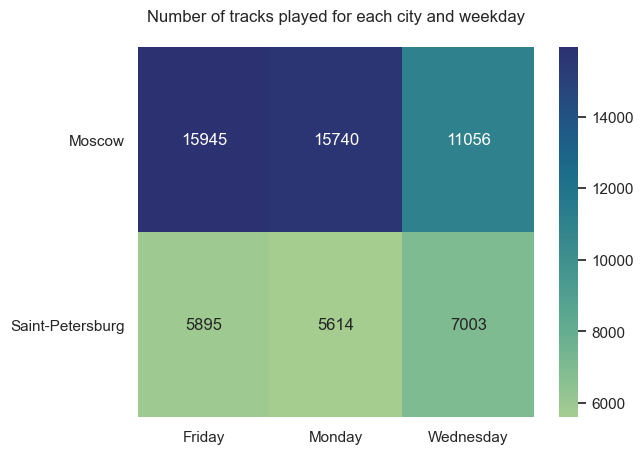

In [15]:
# Building a heatmap
sns.set_theme(style="darkgrid")

info = pd.DataFrame(data=num_track_plays, columns=days, index=cities)
heatmap = sns.heatmap(data=info, annot=True, fmt=".0f", cmap="crest")

heatmap.set(title="Number of tracks played for each city and weekday\n")
plt.yticks(rotation=0)
plt.show()

**Conclusion (Hypothesis 1)**

Data shows difference in user behavior:

* Number of track plays in Moscow peaks on Monday and Friday, while it declines on Wednesday;
* In Saint-Petersburg, conversely, users listen to music more frequently on Wednesday.

Thus, the data confirms the first hypothesis: users from Moscow and Saint-Petersburg indeed listen to music differently.

### H2: Monday morning and Friday evening - different music or the same?

According to the second hypothesis, users in Moscow and Saint-Petersburg differ in their music genre preferences on Monday morning. Likewise, genres differ on Friday evening as well - depending on the city.

Let's create two variables and let them store two DataFrames, where each one will contain information about a specific city.

In [16]:
moscow_general = music_data[music_data["city"] == "Moscow"]
spb_general = music_data[music_data["city"] == "Saint-Petersburg"]

Now, in order to test the hypothesis, we need use a function called `genre_weekday()` from `music` module. The function will return information about top-10 genres of tracks played on a particular day between two time points.

In [17]:
# Computing top-10 genres
moscow_monday_morning = genre_weekday(
    data=moscow_general, day="Monday", time_start="07:00", time_end="11:00"
)
moscow_friday_evening = genre_weekday(
    data=moscow_general, day="Friday", time_start="17:00", time_end="23:00"
)
spb_monday_morning = genre_weekday(
    data=spb_general, day="Monday", time_start="07:00", time_end="11:00"
)
spb_friday_evening = genre_weekday(
    data=spb_general, day="Friday", time_start="17:00", time_end="23:00"
)

# Concatenating results from different cities
genre_comparison_df = pd.concat(
    [
        moscow_monday_morning,
        moscow_friday_evening,
        spb_monday_morning,
        spb_friday_evening,
    ],
    axis=1,
)
# Tweaking visuals
cities = ["Moscow", "Saint-Petersburg"]
daytime = ["Morning", "Evening"]
genre_comparison_df.columns = pd.MultiIndex.from_product(
    [cities, daytime], names=["City", "Daytime"]
)
genre_comparison_df = genre_comparison_df.fillna("-")

display(genre_comparison_df)

City         Moscow         Saint-Petersburg        
Daytime     Morning Evening          Morning Evening
genre                                               
pop           781.0   713.0            218.0   256.0
dance         549.0   495.0            182.0   210.0
electronic    480.0   482.0            147.0   216.0
rock          474.0   517.0            162.0   216.0
hiphop        286.0   273.0             80.0    97.0
ruspop        186.0   170.0             64.0       -
world         181.0   208.0                -    54.0
rusrap        175.0   142.0             55.0    59.0
alternative   164.0   163.0             58.0    63.0
unknown       161.0       -                -       -
classical         -   163.0             40.0    60.0
jazz              -       -             44.0    61.0

**Conclusion (Hypothesis 2)**

By comparing the top-10 genres on Monday morning, the following conclusion can be drawn:

* Users in Moscow and Saint-Petersburg listen to similar music. The only difference is that Moscow rating includes `world` genre, while that for Saint-Petersburg includes `jazz` and `classical` music genres.
* In Moscow there are so many missing values that `unknown` genre took the 10th place in the rating of the most popular genres. Hence, missing values account for a substantial fraction of data and are highly likely to affect the results. 
* Friday evening does not change the results: some genres ascend and descend across the top-10 rating but in general rating stays the same. 

Thus, the second hypothesis has been partially confirmed:

* Users listen to similar music at the beginning and the end of the week. 
* We were not able to detect a distinct difference between Moscow and Saint-Petersburg. Users in Moscow often listen to the russian popular music (`ruspop`), while users in Saint-Peterburg - jazz (`jazz`). 

However, missing values do not allow accurately confirming the above results. Moscow data has so many of them that it is likely that the top-10 rating could have looked differently should we have had all information.

### H3: Moscow and Saint-Petersburg - two different capitals with different music preferences?

The third hypothesis states that Saint-Petersburg is a city where `rusrap` genre prevails, while Moscow is popular with `pop`.

We can start by grouping the table by genre and counting the number of tracks played in Moscow.

In [18]:
# Computing top-10 genres for cities
moscow_genres = (
    moscow_general.groupby("genre")["genre"]
    .count()
    .sort_values(ascending=False)
    .head(10)
)
spb_genres = (
    spb_general.groupby("genre")["genre"].count().sort_values(ascending=False).head(10)
)

# Combining results
city_genres_comparison_df = pd.concat([moscow_genres, spb_genres], axis=1)
city_genres_comparison_df.columns = ["Moscow", "Saint-Petersburg"]

display(city_genres_comparison_df)

,Moscow,Saint-Petersburg
genre,,
pop,5892,2431
dance,4435,1932
rock,3965,1879
electronic,3786,1736
hiphop,2096,960
classical,1616,646
world,1432,515
alternative,1379,649
ruspop,1372,538


**Conclusion (Hypothesis 3)**

The third hypothesis has been partially confirmed:

* Pop-music (`pop`) is the most popular genre in Moscow as the hypothesis stipulated. Besides, top-10 genres also include a closer music genre - russian pop music (`ruspop`).
* Contrary to expectations, `rusrap` is as popular in Moscow as it is in Saint-Petersburg.

## General results

We have managed to test the following working hypotheses:

* There are differences in musical preferences in Moscow and Saint-Petersburg;
* Top-10 rating of popular genres on Monday morning and Friday evening can be characterized by distinct differences;
* Population of two cities prefers different music genres.

**Key takeaways**

Moscow and Saint-Petersburg are similar in musical tastes: pop music is preferred everywhere. Additionally, it is not contingent upon weekday: people always listen to what they like. However, comparing by weekday, Moscow users listen to music more on Monday and Friday than Wednesday, while in Saint-Peterburg the reverse takes place: users play tracks more frequently on Wednesday relative to Monday and Friday.

Thus, the first hypothesis has been confirmed and the other two - partially confirmed.